Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

Importing Skin Cancer Data¶

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [5]:
# mount google drive.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# Unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [7]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [8]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


There are 2239 data set for training data and 118 for test data.

**Create a dataset**


Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),label_mode='categorical',
                                                              seed=123,subset="training",validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),label_mode='categorical',
                                                              seed=123,subset="validation",validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Visualize the data**

create a code to visualize one instance of all the nine classes present in the dataset

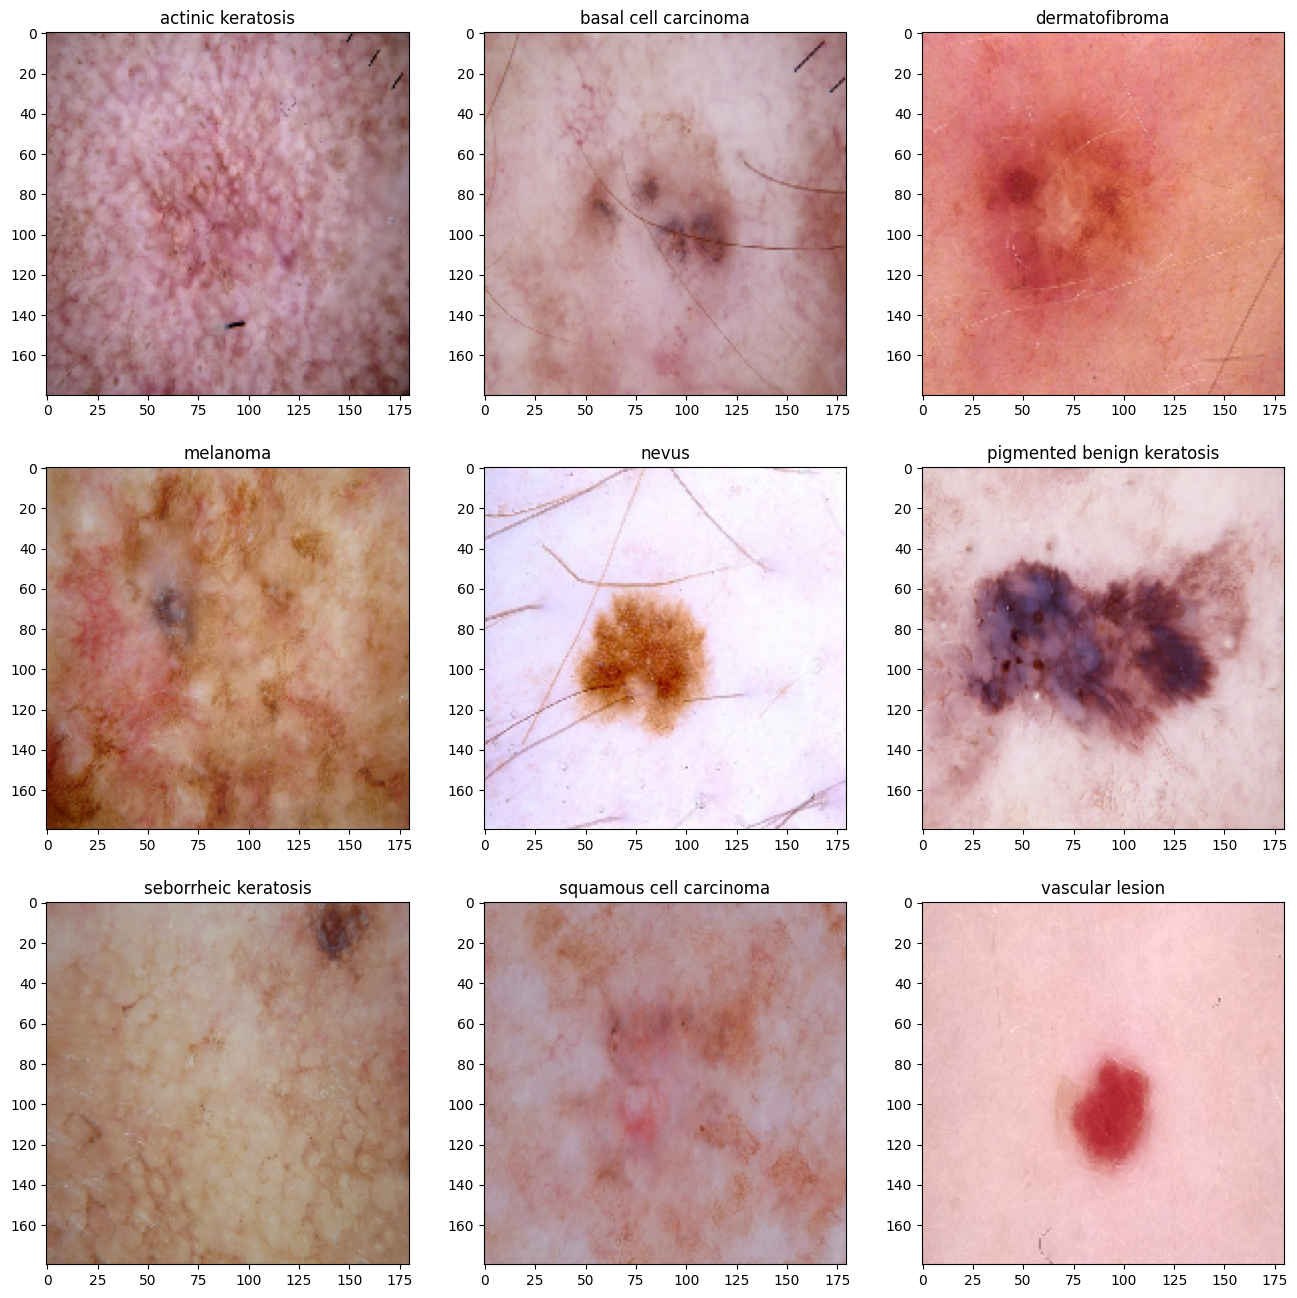

In [13]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

#Dictionary to store the path of image as per the class
image_path = {}

for c in class_names:
    image_path[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(16,16))
index = 0
for c in class_names:
    path_list1 = image_path[c][:1]
    index =index+1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list1[0],target_size=(img_height,img_width)))
    plt.title(c)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Create the model**


Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [15]:

input_shape = (img_height,img_width,3)

model = Sequential()    #Sequential allows you to create models layer-by-layer

#First Convulation Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())   #Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.

#Dense Layer
model.add(layers.Dense(512,activation='relu'))

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))


**Compile the model**

In [16]:

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [17]:
# summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

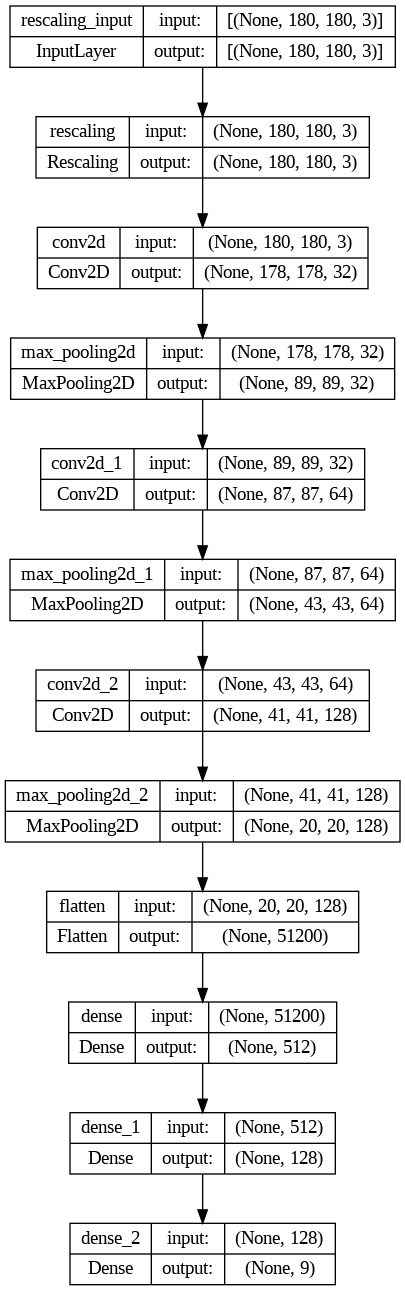

In [18]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Train the model

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 28s 90ms/step - loss: 2.0074 - accuracy: 0.2628 - val_loss: 1.7260 - val_accuracy: 0.3781
Epoch 2/20
56/56 [==============================] - 2s 42ms/step - loss: 1.6109 - accuracy: 0.4230 - val_loss: 1.4847 - val_accuracy: 0.4855
Epoch 3/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5141 - accuracy: 0.4615 - val_loss: 1.4477 - val_accuracy: 0.5056
Epoch 4/20
56/56 [==============================] - 2s 38ms/step - loss: 1.3805 - accuracy: 0.5218 - val_loss: 1.4659 - val_accuracy: 0.4877
Epoch 5/20
56/56 [==============================] - 2s 39ms/step - loss: 1.3550 - accuracy: 0.5140 - val_loss: 1.4452 - val_accuracy: 0.4810
Epoch 6/20
56/56 [==============================] - 2s 38ms/step - loss: 1.2710 - accuracy: 0.5508 - val_loss: 1.3753 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 2s 38ms/step - loss: 1.2062 - accuracy: 0.5603 - val_loss: 1.3949 - val_accuracy: 0.5257
Epoch 8/20
5

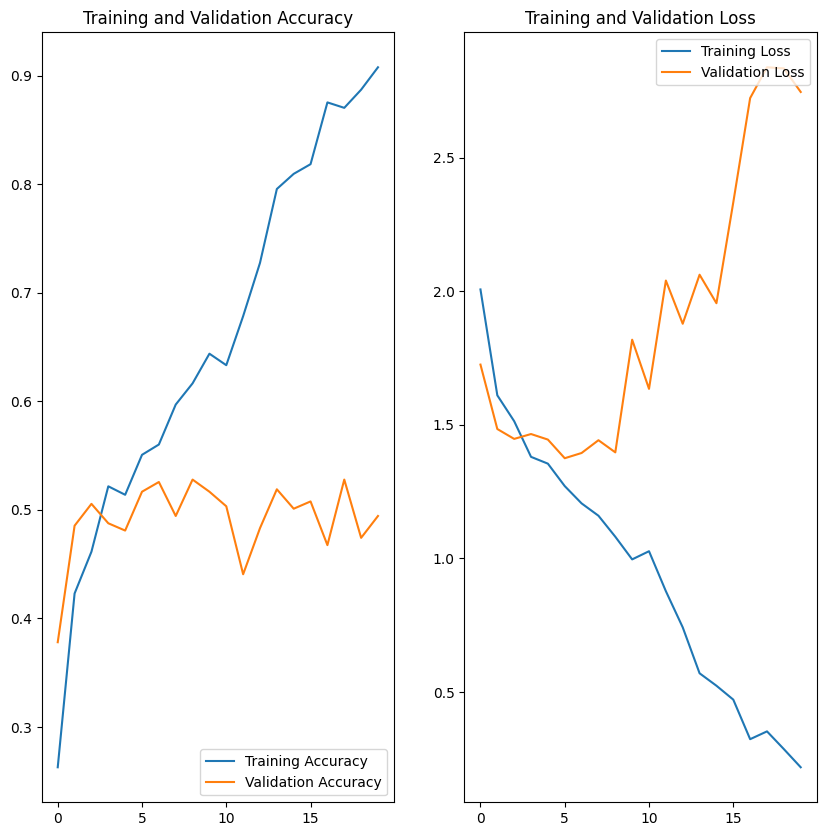

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model is overfitting.



From the above Training vs Validation accuracy graph we can see that as the epoch increases the difference between Training accuracy and validation accuracy increases.

In [21]:
#Data augumentation strategy.

rescale = tf.keras.Sequential([
  #To rescale an input in the [0, 255] range to be in the [0, 1] range
  layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  #Randomly flip each image horizontally and vertically.
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),

  #Randomly rotate each image.
  layers.experimental.preprocessing.RandomRotation(0.2),

  #Randomly zoom each image during training.
  layers.experimental.preprocessing.RandomZoom(0.2),

  #Randomly translate each image during training.
  layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
])

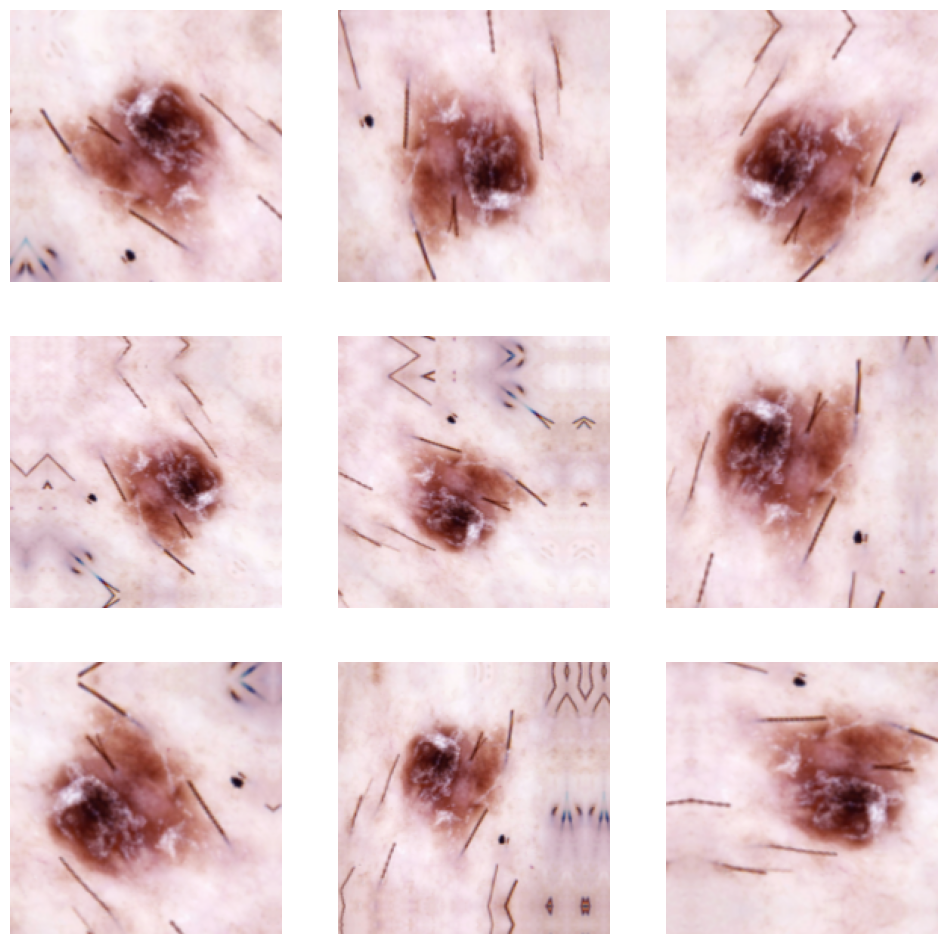

In [22]:
#Visualize the augmentation image
plt.figure(figsize=(12, 12))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [23]:
## Model 2 Creation

#Dropout layer: randomly sets input units to 0 with a frequency of rate at each step during training time,
#which helps prevent overfitting.Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.


## Your code goes here
model2 = Sequential()                     #Sequential allows you to create models layer-by-layer

model2.add(data_augmentation)             #Augmentation layer
model2.add(rescale)                       #Rescaling layer

#First Convulation Layer
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Second Convulation Layer
model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Third Convulation Layer
model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model2.add(layers.Flatten())

#Dense Layer
model2.add(layers.Dense(512,activation='relu'))

#Dense Layer
model2.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model2.add(layers.Dropout(0.50))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model2.add(layers.Dense(len(class_names),activation='softmax'))

In [24]:

model2.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [35]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 89, 89, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                      

In [26]:


epochs =20
history2 = model2.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)


Epoch 1/20
56/56 [==============================] - 9s 67ms/step - loss: 2.5355 - accuracy: 0.1808 - val_loss: 2.0937 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 4s 63ms/step - loss: 2.0667 - accuracy: 0.1981 - val_loss: 2.0800 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 4s 66ms/step - loss: 2.0576 - accuracy: 0.1886 - val_loss: 2.0536 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 4s 65ms/step - loss: 1.9749 - accuracy: 0.2533 - val_loss: 1.9191 - val_accuracy: 0.3020
Epoch 5/20
56/56 [==============================] - 4s 63ms/step - loss: 1.8381 - accuracy: 0.3209 - val_loss: 1.9118 - val_accuracy: 0.3087
Epoch 6/20
56/56 [==============================] - 4s 63ms/step - loss: 1.7484 - accuracy: 0.3605 - val_loss: 1.7116 - val_accuracy: 0.3669
Epoch 7/20
56/56 [==============================] - 4s 69ms/step - loss: 1.6746 - accuracy: 0.4062 - val_loss: 1.6184 - val_accuracy: 0.4295
Epoch 8/20
56

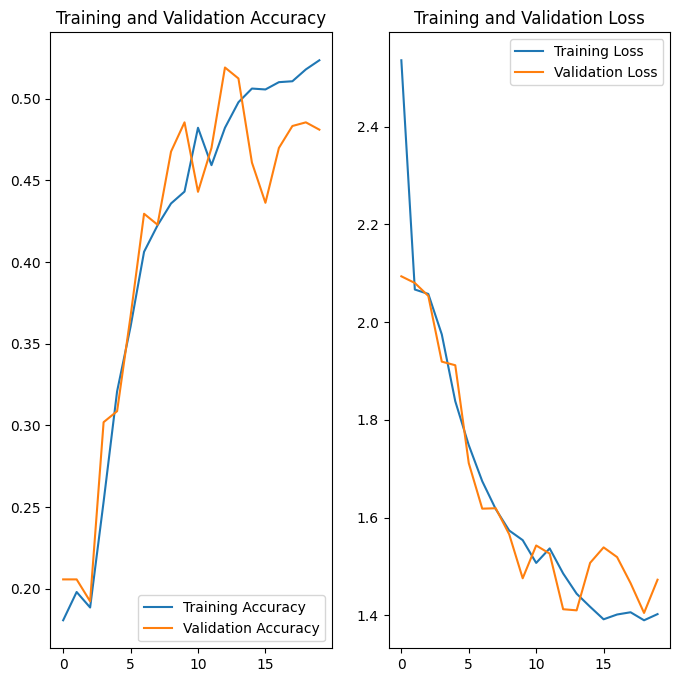

In [27]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


- overfitting issue is reduced with dropout and augmentaion layer. But still there si lot of fluctuations in the accuracy and loss between training and validation.

- We need to check for class imbalance,

Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:

def class_distribution_count(directory1):

    #count number of image in each classes
    count12= []
    for path in pathlib.Path(directory1).iterdir():
        if path.is_dir():
            count12.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory1)
                    if os.path.isdir(os.path.join(directory1, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count12)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

Class  No. of Image
0  pigmented benign keratosis           462
1             vascular lesion           139
2                       nevus           357
3        basal cell carcinoma           376
4              dermatofibroma            95
5                    melanoma           438
6        seborrheic keratosis            77
7     squamous cell carcinoma           181
8           actinic keratosis           114

<Axes: xlabel='No. of Image', ylabel='Class'>

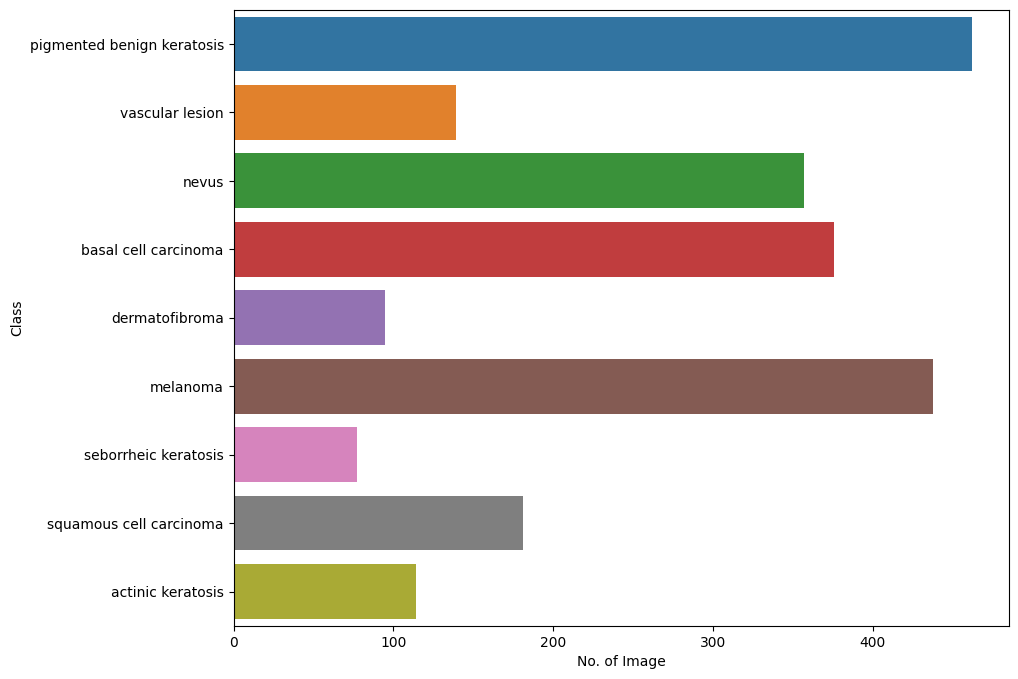

In [29]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")



1.   melanoma, basal cell carcinoma, nevus and pigmented beningin keratosis show class imblance, more data sets are available for these four classes and these classes dominates.
2.   seborrheic keratosis shows least number of samples with 77.

With these data we see that there is class imbalance. We can use python package known as Augmentor to add more samples across all the class.



In [30]:
!pip install Augmentor

In [31]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C5AD9FA00A0>: 100%|██████████| 500/500 [00:16<00:00, 30.18 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C5AD9FA3790>: 100%|██████████| 500/500 [00:15<00:00, 31.75 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C5ADA880D00>: 100%|██████████| 500/500 [00:16<00:00, 30.69 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C5AD96283A0>: 100%|██████████| 500/500 [01:17<00:00,  6.48 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7C5AD9657DF0>: 100%|██████████| 500/500 [01:18<00:00,  6.39 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C5ADA8BB3D0>: 100%|██████████| 500/500 [00:16<00:00, 30.73 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C5ADAB15750>: 100%|██████████| 500/500 [00:37<00:00, 13.18 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C5AD9FA1D80>: 100%|██████████| 500/500 [00:16<00:00, 30.66 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C5ADAA0A1D0>: 100%|██████████| 500/500 [00:16<00:00, 29.90 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.

In [32]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [36]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [37]:
#dataframe that store path and label of the images generated by Augmentor
df3 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [38]:
#label count.
df3['Label'].value_counts()

pigmented benign keratosis    500
vascular lesion               500
nevus                         500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
seborrheic keratosis          500
squamous cell carcinoma       500
actinic keratosis             500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [39]:
batch_size = 32
img_height = 180
img_width = 180

In [40]:
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

#Training dataset.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,    #20% fraction of data to reserve for validation.
  subset = "training",
  image_size=(img_height, img_width),label_mode='categorical',  #label_mode='categorical' means that the labels are encoded as a categorical vector
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [41]:
#Validation dataset.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),label_mode='categorical',   #label_mode='categorical' means that the labels are encoded as a categorical vector
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


**Create Model**

In [50]:
## Model 3 Creation


model3 = Sequential()

model3.add(rescale)   #Rescaling Layer

#First Convulation layer
model3.add(layers.Conv2D(32,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Second Convulation Layer
model3.add(layers.Conv2D(64,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Third Convulation Layer
model3.add(layers.Conv2D(128,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
model3.add(layers.Flatten())

#Dense Layer
model3.add(layers.Dense(512,activation='relu'))

#Dropout layer
model3.add(layers.Dropout(0.25))

#Batch normalization: is a method used to make artificial neural networks faster and more stable through normalization
#of the layers' inputs by re-centering and re-scaling.
model3.add(layers.BatchNormalization())

#Dense Layer
model3.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model3.add(layers.Dropout(0.50))

#Batch normalization
model3.add(layers.BatchNormalization())

#Dense layer with Softmax activation function.
model3.add(layers.Dense(len(class_names),activation='softmax'))

**Compile Model**

In [51]:

model3.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])


**Train your model**

In [52]:
epochs = 30
history3 = model3.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)

Epoch 1/30
169/169 [==============================] - 33s 171ms/step - loss: 2.4200 - accuracy: 0.1916 - val_loss: 2.5322 - val_accuracy: 0.1737
Epoch 2/30
169/169 [==============================] - 30s 171ms/step - loss: 1.8771 - accuracy: 0.3084 - val_loss: 1.7793 - val_accuracy: 0.3304
Epoch 3/30
169/169 [==============================] - 29s 168ms/step - loss: 1.6719 - accuracy: 0.3676 - val_loss: 3.0056 - val_accuracy: 0.2309
Epoch 4/30
169/169 [==============================] - 29s 167ms/step - loss: 1.5738 - accuracy: 0.4034 - val_loss: 2.5578 - val_accuracy: 0.2732
Epoch 5/30
169/169 [==============================] - 29s 169ms/step - loss: 1.5073 - accuracy: 0.4162 - val_loss: 1.8985 - val_accuracy: 0.3675
Epoch 6/30
169/169 [==============================] - 29s 169ms/step - loss: 1.4557 - accuracy: 0.4421 - val_loss: 1.6209 - val_accuracy: 0.3979
Epoch 7/30
169/169 [==============================] - 33s 192ms/step - loss: 1.3759 - accuracy: 0.4735 - val_loss: 1.6768 - val_ac

**Validate model**

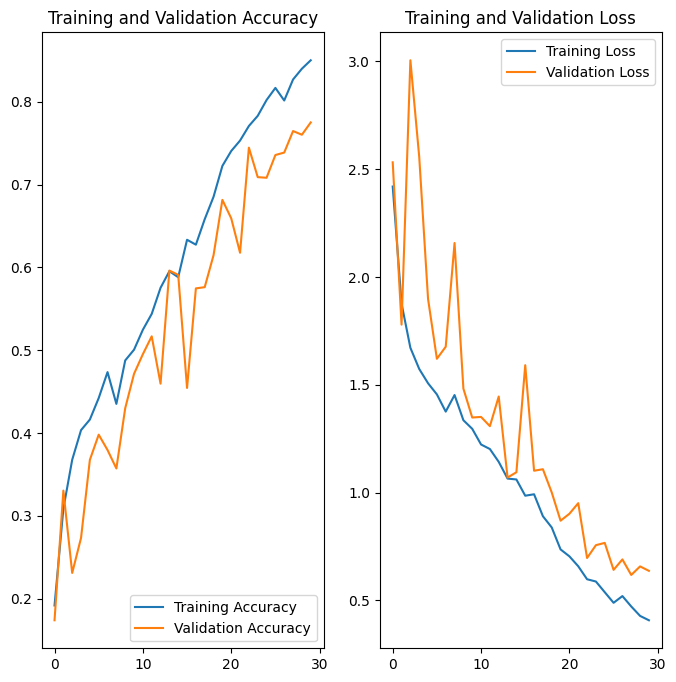

In [53]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

 -  In model3 Training accuracy and validation accuracy increases. The difference also remains same.
 -  Model overfitting issue is solved.
 -  Class rebalance helps in augmentation and achieving the best Training and validation accuracy.

In [83]:
## Model 3 Creation


model4 = Sequential()
model4.add(data_augmentation)             #Augmentation layer
model4.add(rescale)   #Rescaling Layer

#First Convulation layer
model4.add(layers.Conv2D(32,kernel_size=(2,2),activation='relu'))
model4.add(layers.MaxPool2D(pool_size=(2,2)))
model4.add(layers.Dropout(0.25))

#Second Convulation Layer
model4.add(layers.Conv2D(64,kernel_size=(2,2),activation='relu'))
model4.add(layers.MaxPool2D(pool_size=(2,2)))
model4.add(layers.Dropout(0.25))


#Second Convulation Layer
model4.add(layers.Conv2D(64,kernel_size=(2,2),activation='relu'))
model4.add(layers.MaxPool2D(pool_size=(2,2)))
model4.add(layers.Dropout(0.25))

#Third Convulation Layer
model4.add(layers.Conv2D(128,kernel_size=(2,2),activation='relu'))
model4.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
model4.add(layers.Flatten())

#Dense Layer
model4.add(layers.Dense(512,activation='relu'))

#Dropout layer
model4.add(layers.Dropout(0.25))

#Batch normalization: is a method used to make artificial neural networks faster and more stable through normalization
#of the layers' inputs by re-centering and re-scaling.
model4.add(layers.BatchNormalization())

#Dense Layer
model4.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model4.add(layers.Dropout(0.50))

#Batch normalization
model4.add(layers.BatchNormalization())

#Dense layer with Softmax activation function.
model4.add(layers.Dense(len(class_names),activation='softmax'))

In [84]:
model4.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [85]:
epochs = 30
history4 = model4.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)

Epoch 1/30
169/169 [==============================] - 34s 169ms/step - loss: 2.3756 - accuracy: 0.1999 - val_loss: 2.3235 - val_accuracy: 0.2450
Epoch 2/30
169/169 [==============================] - 29s 167ms/step - loss: 1.9013 - accuracy: 0.2943 - val_loss: 3.4243 - val_accuracy: 0.1626
Epoch 3/30
169/169 [==============================] - 29s 167ms/step - loss: 1.6788 - accuracy: 0.3731 - val_loss: 1.9084 - val_accuracy: 0.3430
Epoch 4/30
169/169 [==============================] - 29s 166ms/step - loss: 1.5812 - accuracy: 0.3906 - val_loss: 1.6781 - val_accuracy: 0.3653
Epoch 5/30
169/169 [==============================] - 29s 166ms/step - loss: 1.6153 - accuracy: 0.3756 - val_loss: 2.0802 - val_accuracy: 0.2769
Epoch 6/30
169/169 [==============================] - 29s 167ms/step - loss: 1.5231 - accuracy: 0.4123 - val_loss: 1.7220 - val_accuracy: 0.3549
Epoch 7/30
169/169 [==============================] - 29s 168ms/step - loss: 1.4806 - accuracy: 0.4303 - val_loss: 1.8886 - val_ac

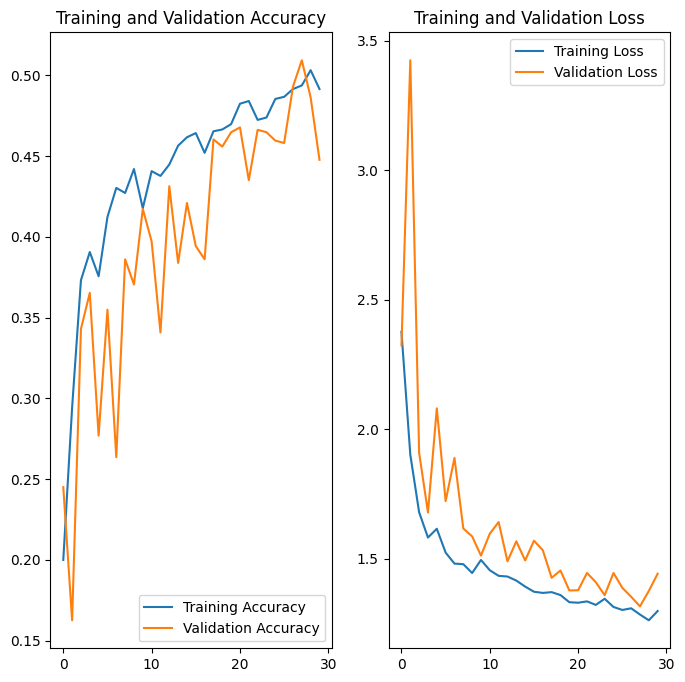

In [86]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 21ms/step
Actual Class melanoma
Predictive Class melanoma


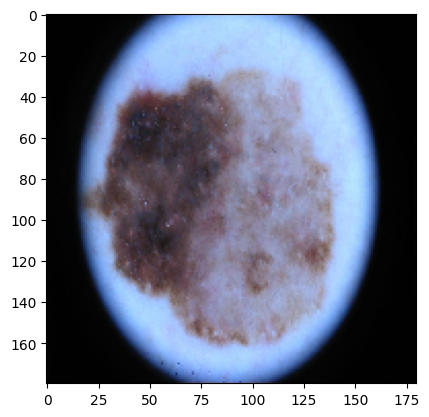

In [90]:
from glob import glob

w=3
Test_image_path = os.path.join(data_dir_test, class_names[w], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model4.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[w] +'\n'+ "Predictive Class "+pred_class )